In [ ]:
! pip install Sastrawi
import string
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize, word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import io
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import xgboost as xgb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data_shangrila1.xlsx to data_shangrila1.xlsx


In [ ]:
df = pd.read_excel("data_shangrila1.xlsx")
df

,Ulasan,Sentimen
0,"Menginap 7 hari disini,\nkamarnya bagus, fasil...",Positif
1,"makanannya kurang enak, mending jajan diluar",negatif
2,"Bener2 memuaskan nginep disini, semua pelayann...",positif
3,"tempat yang bagus untuk menginap, pekerjanya r...",positif
4,"Pengalaman menginap yang menyenangkan, kamar n...",positif
...,...,...
3713,hotel terbaik di surabaya,positif
3714,terlihat sangat mewah dari luar,positif
3715,hotel yang sangat nyaman untuk di tinggali,positif
3716,Hotel bintang 5 terbaik di surabaya,positif


In [ ]:
# Case Folding
def pre_process(text):
 text = text.lower()
 return text
df['Ulasan'] = df['Ulasan'].apply(lambda x:pre_process(x))
df

,Ulasan,Sentimen
0,"menginap 7 hari disini,\nkamarnya bagus, fasil...",Positif
1,"makanannya kurang enak, mending jajan diluar",negatif
2,"bener2 memuaskan nginep disini, semua pelayann...",positif
3,"tempat yang bagus untuk menginap, pekerjanya r...",positif
4,"pengalaman menginap yang menyenangkan, kamar n...",positif
...,...,...
3713,hotel terbaik di surabaya,positif
3714,terlihat sangat mewah dari luar,positif
3715,hotel yang sangat nyaman untuk di tinggali,positif
3716,hotel bintang 5 terbaik di surabaya,positif


In [ ]:
# Cleaning : pembersihan kalimat dari atribut-atribut yang mengganggu, seperti angka, tanda baca, dan karakter kosong
def pre_process(text):
 # Menghapus karakter angka.
 text = re.sub(r"\d+", "", text)
 # Menghapus karakter tanda baca.
 text = text.translate(str.maketrans("","",string.punctuation))
 # Menghapus karakter kosong.
 text = text.strip()
 return text
df['Ulasan'] = df['Ulasan'].apply(lambda x:pre_process(x))
df

,Ulasan,Sentimen
0,menginap hari disini\nkamarnya bagus fasilita...,Positif
1,makanannya kurang enak mending jajan diluar,negatif
2,bener memuaskan nginep disini semua pelayannya...,positif
3,tempat yang bagus untuk menginap pekerjanya ra...,positif
4,pengalaman menginap yang menyenangkan kamar ny...,positif
...,...,...
3713,hotel terbaik di surabaya,positif
3714,terlihat sangat mewah dari luar,positif
3715,hotel yang sangat nyaman untuk di tinggali,positif
3716,hotel bintang terbaik di surabaya,positif


In [ ]:
# Tokenizing : Memotong kalimat agar terpisah-pisah menjadi satuan kata
def pre_process(text):
 text = nltk.tokenize.word_tokenize(text)
 return text
df['Ulasan'] = df['Ulasan'].apply(lambda x:pre_process(x))
df

,Ulasan,Sentimen
0,"[menginap, hari, disini, kamarnya, bagus, fasi...",Positif
1,"[makanannya, kurang, enak, mending, jajan, dil...",negatif
2,"[bener, memuaskan, nginep, disini, semua, pela...",positif
3,"[tempat, yang, bagus, untuk, menginap, pekerja...",positif
4,"[pengalaman, menginap, yang, menyenangkan, kam...",positif
...,...,...
3713,"[hotel, terbaik, di, surabaya]",positif
3714,"[terlihat, sangat, mewah, dari, luar]",positif
3715,"[hotel, yang, sangat, nyaman, untuk, di, tingg...",positif
3716,"[hotel, bintang, terbaik, di, surabaya]",positif


In [ ]:
# Stopword Removal : menghapus kata-kata yang tidak relevan / tidak penting
def pre_process(text):
 factory = StopWordRemoverFactory()
 stopword = factory.create_stop_word_remover()
 text = [stopword.remove(word) for word in text]
 return text
df['Ulasan'] = df['Ulasan'].apply(lambda x:pre_process(x))
df

,Ulasan,Sentimen
0,"[menginap, hari, disini, kamarnya, bagus, fasi...",Positif
1,"[makanannya, kurang, enak, mending, jajan, dil...",negatif
2,"[bener, memuaskan, nginep, disini, semua, pela...",positif
3,"[tempat, , bagus, , menginap, pekerjanya, rama...",positif
4,"[pengalaman, menginap, , menyenangkan, kamar, ...",positif
...,...,...
3713,"[hotel, terbaik, , surabaya]",positif
3714,"[terlihat, sangat, mewah, , luar]",positif
3715,"[hotel, , sangat, nyaman, , , tinggali]",positif
3716,"[hotel, bintang, terbaik, , surabaya]",positif


In [ ]:
# Stemming : menghilangkan imbuhan
def pre_process(text):
 factory = StemmerFactory()
 stemmer = factory.create_stemmer()
 text = [stemmer.stem(word) for word in text]
 return text
df['Ulasan'] = df['Ulasan'].apply(lambda x:pre_process(x))
df
df_stem = df

In [ ]:
# label encoding
from sklearn.preprocessing import LabelEncoder
labels = df['Sentimen'].values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
encoded_labels

array([0, 1, 2, ..., 2, 2, 2])

In [ ]:
# TF-IDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
data_clean = df
data_clean = data_clean.astype({'Sentimen' : 'category'})
data_clean = data_clean.astype({'Ulasan' : 'string'})
tf = TfidfVectorizer()
text_tf = tf.fit_transform(data_clean['Ulasan'].astype('U'))
tokens_tf=tf.get_feature_names_out()
df = pd.DataFrame(data = text_tf.toarray(),columns = tokens_tf)
df

,aaabbb,abai,abiss,abisssbersih,about,above,absen,ac,acar,acara,...,year,years,yes,yg,yo,you,yudhoyono,yus,yusuf,zaman
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.to_excel(r'TFIDF_shangrila.xlsx', sheet_name='TFIDF', index=False)

In [ ]:
#splitting data
from sklearn.model_selection import train_test_split
X = text_tf.toarray()
y = encoded_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate some example data
X, y = make_classification(n_samples=3719, n_features=10, random_state=42)

# Create a logistic regression classifier
model = LogisticRegression()

# Initialize RFE
rfe = RFE(model, n_features_to_select=5)  # Select top 5 features

# Fit RFE
fit = rfe.fit(X, y)

# Print the ranking of each feature
print("Feature Ranking:", fit.ranking_)

# Print selected features
print("Selected Features:", fit.support_)

# You can also access the ranking of features directly from RFE object
print("Feature Ranking from RFE:", rfe.ranking_)

# You can also access the support of features directly from RFE object
print("Selected Features from RFE:", rfe.support_)

Feature Ranking: [1 5 1 1 3 1 2 4 6 1]
Selected Features: [ True False  True  True False  True False False False  True]
Feature Ranking from RFE: [1 5 1 1 3 1 2 4 6 1]
Selected Features from RFE: [ True False  True  True False  True False False False  True]


In [ ]:
class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=1000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        # pada index ke 0 fitur sisipkan 1 (bias)
        X = np.insert(X, 0, 1, axis=1)

        '''
          Inisiasi nilai awal bobot diambil dari panjang fitur
          kemudian diisi dengan 0, misal panjang 2 berarti [0, 0]
        '''
        self.weights = np.zeros(X.shape[1])

        # Proses memperbarui bobot / training
        for i in range(self.num_iterations):
            # y_hat prediksi yang dihasilkan oleh model
            y_hat = self.sigmoid(np.dot(X, self.weights))

            # hitung error
            error = y_hat - y
            # perbarui bobot
            # bobot baru = bobot lama - learning rate * (X * error)
            self.weights -= self.learning_rate * np.dot(X.T, error)

            # Print progress
            if self.verbose and i % 100 == 0 or i == 999:
                print(f"Iteration {i}: Cost = {self.loss(X, y)} Weight {i}: {self.weights}")

    def predict(self, X):
      # pada index ke 0 fitur sisipkan 1 (bias)
      X = np.insert(X, 0, 1, axis=1)

      # y_hat prediksi yang dihasilkan oleh model
      y_hat = self.sigmoid(np.dot(X, self.weights))

      # bulatkan angka hasil predictions to 0 or 1 (if >= 0.5 == 1 else 0)
      return np.round(y_hat)

    def loss(self, X, y):
      y_hat = self.sigmoid(np.dot(X, self.weights))
      loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

      return loss_result

    def accuracy(self, X, y):
      # hasil prediksi model
      y_pred = self.predict(X)

      # hitung akurasi = rata-rata dari nilai yang sama antara y hasil prediksi dengan y aktual dari dataset
      accuracy_result = np.mean(y_pred == y)

      return accuracy_result

In [ ]:
from sklearn.model_selection import train_test_split

X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X, y, random_state=37, test_size = 0.3)

In [ ]:
import time

model = LogisticRegression(learning_rate=0.01, num_iterations=1000, verbose=True)

t0_lr = time.time()

model.fit(X_lr_train, y_lr_train)

t1_lr = time.time()

Iteration 0: Cost = nan Weight 0: [-1.75000000e-01  1.60379631e-01  6.93175129e-02  3.66330352e-01
 -5.32448997e+00 -8.83430953e-03 -5.48662031e+00  4.57172708e-01
  2.14544331e-01 -1.80175192e-01  1.33057106e+01]
Iteration 100: Cost = nan Weight 100: [ 0.57070968  0.91817955  0.17309791  0.03510203 -2.97971056  0.055515
 -3.75246194  0.52705499  0.18410448 -0.06402895  8.26902884]
Iteration 200: Cost = nan Weight 200: [ 0.38171111  1.00283523  0.21643073  0.11195138 -3.25730088  0.04167077
 -4.10131572  0.39364416  0.19316227  0.02732342  9.0384968 ]
Iteration 300: Cost = 0.2695728265836748 Weight 300: [-0.33517911  0.83187671  0.26168319 -0.08183201 -2.02644028  0.07683558
 -2.72275313  0.38361083  0.04428758  0.05466321  5.82963966]
Iteration 400: Cost = 0.20628069124147463 Weight 400: [-0.05782841  0.64405572  0.08834847 -0.01928628 -0.83248779  0.01968605
 -1.36742489  0.12638501  0.03341352  0.00743181  2.69516165]
Iteration 500: Cost = nan Weight 500: [-0.50803762  1.15992206  0

<ipython-input-77-076b3974253d>:47: RuntimeWarning: divide by zero encountered in log
  loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
<ipython-input-77-076b3974253d>:47: RuntimeWarning: invalid value encountered in multiply
  loss_result = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))


In [ ]:
predictions_lr = model.predict(X_lr_test)

# Record the end time for prediction
t2_lr = time.time()

# Calculate the total time taken for training and prediction
time_linear_train_lr = t1_lr - t0_lr
time_linear_predict_lr = t2_lr - t1_lr

# Print the training and prediction times in the specified format
print("EN Training time: %fs; Prediction time: %fs" % (time_linear_train_lr, time_linear_predict_lr))

EN Training time: 0.146638s; Prediction time: 3.256702s


In [ ]:
# Assuming you have a LogisticRegression instance named 'model'
accuracy = model.accuracy(X_lr_test, y_lr_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.9238351254480287


Logistic Regression
Accuracy  =  92.38 %
Recall    =  94.59 %
Precision =  90.94 %
F1-Score  =  92.73 %

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       543
           1       0.91      0.95      0.93       573

    accuracy                           0.92      1116
   macro avg       0.92      0.92      0.92      1116
weighted avg       0.92      0.92      0.92      1116


Logistic Regression Confusion Matrix Display
[[489  54]
 [ 31 542]]



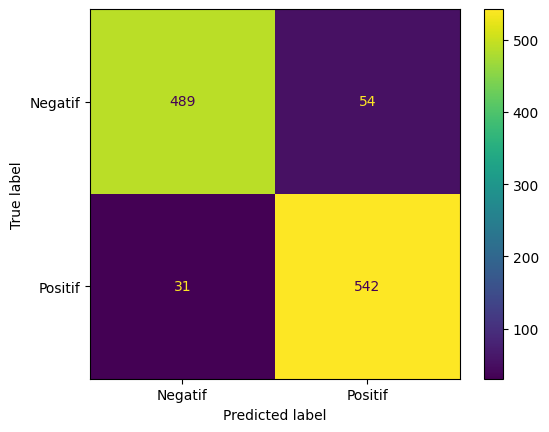

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

print("Logistic Regression")
print('Accuracy  = ', round(accuracy_score(y_lr_test, predictions_lr)*100,2),'%')
print('Recall    = ', round(recall_score(y_lr_test, predictions_lr)*100,2),'%')
print('Precision = ', round(precision_score(y_lr_test, predictions_lr)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_lr_test, predictions_lr)*100,2),'%')

conf_matrix_lr = confusion_matrix(y_lr_test, predictions_lr )

print("")
print("Logistic Regression Classification Report")
print(classification_report(y_lr_test,predictions_lr))
print("")
print("Logistic Regression Confusion Matrix Display")
print(confusion_matrix(y_lr_test,predictions_lr))
print("")
cm_display_lr = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix_lr, display_labels = ['Negatif', 'Positif'])
cm_display_lr.plot()
plt.show()

In [ ]:
from sklearn.utils import check_random_state
class SVM:
    def __init__(
        self, C=1,
        max_iter=50,
        tol=0.05,
        random_state=None, verbose=0):
        self.C = C
        self.max_iter = max_iter
        self.tol = tol,
        self.random_state = random_state
        self.verbose = verbose

    def projection_simplex(self, v, z=1):
        n_features = v.shape[0]
        u = np.sort(v)[::-1]
        cssv = np.cumsum(u) - z
        ind = np.arange(n_features) + 1
        cond = u - cssv / ind > 0
        rho = ind[cond][-1]
        theta = cssv[cond][-1] / float(rho)
        w = np.maximum(v - theta, 0)
        return w

    def _partial_gradient(self, X, y, i):
        # Partial gradient for the ith sample.
        g = np.dot(X[i], self.coef_.T) + 1
        g[y[i]] -= 1
        return g

    def _violation(self, g, y, i):
        # Optimality violation for the ith sample.
        smallest = np.inf
        for k in range(g.shape[0]):
            if k == y[i] and self.dual_coef_[k, i] >= self.C:
                continue
            elif k != y[i] and self.dual_coef_[k, i] >= 0:
                continue

            smallest = min(smallest, g[k])

        return g.max() - smallest

    def _solve_subproblem(self, g, y, norms, i):
        # Prepare inputs to the projection.
        Ci = np.zeros(g.shape[0])
        Ci[y[i]] = self.C
        beta_hat = norms[i] * (Ci - self.dual_coef_[:, i]) + g / norms[i]
        z = self.C * norms[i]

        # Compute projection onto the simplex.
        beta = self.projection_simplex(beta_hat, z)

        return Ci - self.dual_coef_[:, i] - beta / norms[i]

    def fit(self, X, y):
        n_samples, n_features = X.shape

        n_classes = np.unique(y).size
        self.dual_coef_ = np.zeros((n_classes, n_samples), dtype=np.float64)
        self.coef_ = np.zeros((n_classes, n_features))

        # Pre-compute norms.
        norms = np.sqrt(np.sum(X ** 2, axis=1))

        # Shuffle sample indices.
        rs = check_random_state(self.random_state)
        ind = np.arange(n_samples)
        rs.shuffle(ind)

        violation_init = None
        for it in range(self.max_iter):
            violation_sum = 0

            for ii in range(n_samples):
                i = ind[ii]

                # All-zero samples can be safely ignored.
                if norms[i] == 0:
                    continue

                g = self._partial_gradient(X, y, i)
                v = self._violation(g, y, i)
                violation_sum += v

                if v < 1e-12:
                    continue

                # Solve subproblem for the ith sample.
                delta = self._solve_subproblem(g, y, norms, i)

                # Update primal and dual coefficients.
                self.coef_ = self.coef_.astype(np.complex128)
                self.dual_coef_ = self.dual_coef_.astype(np.complex128)
                delta = delta.astype(np.complex128)

                self.coef_ += np.multiply(delta[:, np.newaxis], X[i][:, np.newaxis].conj().T)
                self.dual_coef_[:, i] += delta

            if it == 0:
                violation_init = violation_sum

            vratio = violation_sum / violation_init

            if vratio < self.tol:
                if self.verbose >= 1:
                    print("Converged")
                break

        return self

    def predict(self, X):
        decision = np.dot(X, self.coef_.T)
        return decision.argmax(axis=1)

In [ ]:
svm = SVM()
svm.fit(X_lr_train, y_lr_train)
svm_pred = svm.predict(X_lr_test)

SVM
Accuracy  =  92.47 %
Recall    =  92.47 %
Precision =  92.48 %
F1-Score  =  92.47 %

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       543
           1       0.92      0.93      0.93       573

    accuracy                           0.92      1116
   macro avg       0.92      0.92      0.92      1116
weighted avg       0.92      0.92      0.92      1116


Logistic Regression Confusion Matrix Display
[[497  46]
 [ 38 535]]



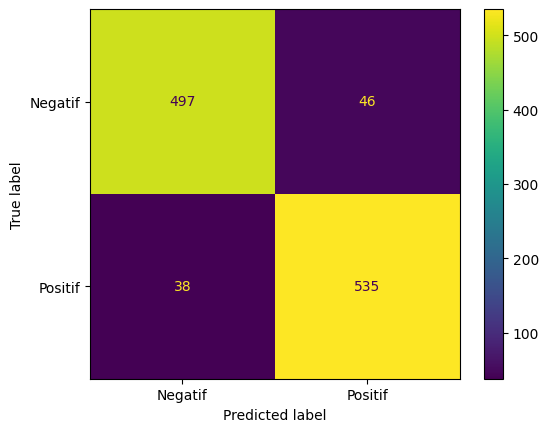

In [ ]:
print("SVM")
print('Accuracy  = ', round(accuracy_score(y_lr_test, svm_pred)*100,2),'%')
print('Recall    = ', round(recall_score(y_lr_test, svm_pred, average = 'weighted', zero_division = 0)*100,2),'%')
print('Precision = ', round(precision_score(y_lr_test, svm_pred, average = 'weighted', zero_division = 0)*100,2),'%')
print('F1-Score  = ', round(f1_score(y_lr_test, svm_pred, average = 'weighted', zero_division = 0)*100,2),'%')

conf_matrix_svm = confusion_matrix(y_lr_test, svm_pred )

print("")
print("Logistic Regression Classification Report")
print(classification_report(y_lr_test,svm_pred))
print("")
print("Logistic Regression Confusion Matrix Display")
print(confusion_matrix(y_lr_test,svm_pred))
print("")
cm_display_svm = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix_svm, display_labels = ['Negatif', 'Positif'])
cm_display_svm.plot()
plt.show()

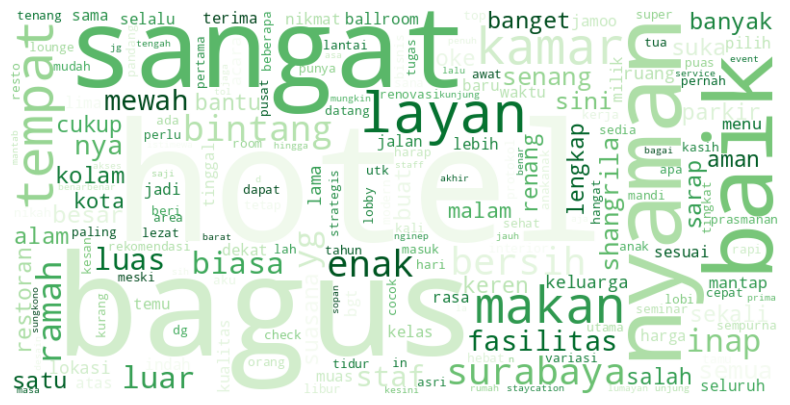

In [ ]:
from wordcloud import WordCloud
data_positif = df_stem[df_stem['Sentimen'] == "positif"]

all_tokens = []
for tokens_list in data_positif['Ulasan']:
    all_tokens.extend(tokens_list)

# Menghitung kemunculan setiap kata
word_count = {}
for token in all_tokens:
    if token in word_count:
        word_count[token] += 1
    else:
        word_count[token] = 1

# Membuat Word Cloud
wordcloud = WordCloud(colormap='Greens', width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

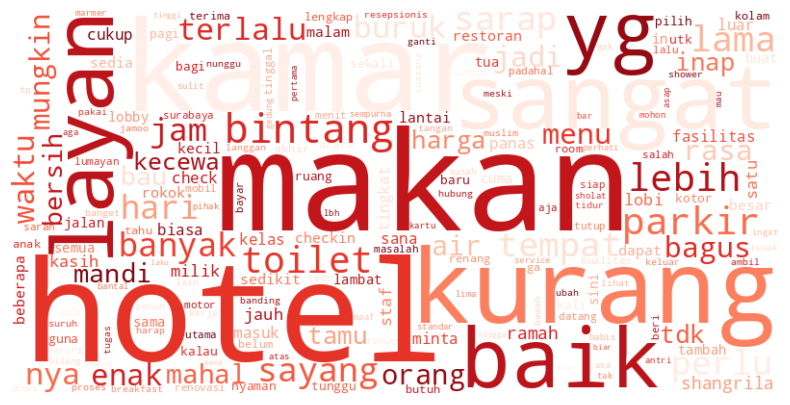

In [ ]:
data_positif = df_stem[df_stem['Sentimen'] == "negatif"]

all_tokens = []
for tokens_list in data_positif['Ulasan']:
    all_tokens.extend(tokens_list)

# Menghitung kemunculan setiap kata
word_count = {}
for token in all_tokens:
    if token in word_count:
        word_count[token] += 1
    else:
        word_count[token] = 1

# Membuat Word Cloud
wordcloud = WordCloud(colormap='Reds', width=800, height=400, background_color='white').generate_from_frequencies(word_count)

# Menampilkan Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()